Требуется визуализировать данные. Предварительно проведено разделение на 5 кластеров. Набор данных обобщает информацию об использовании примерно 9000 активных кредитных карт за последние 6 месяцев. Файл содержит 18 поведенческих переменных для каждого клиента.

<h5 align="center">Словарь данных</h5>
<table>
<thead>
<tr>
<th>Название</th>
<th>Описание</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>CUST_ID</strong></td>
<td>идентификатор держателя кредитной карты</td>
</tr>
<tr>
<td><strong>BALANCE</strong></td>
<td>баланс на счете для совершения покупок</td>
</tr>
<tr>
<td><strong>BALANCE_FREQUENCY</strong></td>
<td>как часто обновляется баланс, оценка от 0 до 1 (1 = часто обновляется, 0 = не часто обновляется)</td>
</tr>
<tr>
<td><strong>PURCHASES</strong></td>
<td>сумма, потраченная на покупки</td>
</tr>
<tr>
<td><strong>ONEOFF_PURCHASES</strong></td>
<td>максимальная сумма покупки без рассрочки</td>
</tr>
<tr>
<td><strong>INSTALLMENTS_PURCHASES</strong></td>
<td>сумма, потраченная на покупки, совершенные в рассрочку</td>
</tr>
<tr>
<td><strong>CASH_ADVANCE</strong></td>
<td>аванс наличными, предоставленный клиенту</td>
</tr>
<tr>
<td><strong>PURCHASES_FREQUENCY</strong></td>
<td>частота совершения покупок, оценка от 0 до 1 (1 = часто, 0 = не часто)</td>
</tr>
<tr>
<td><strong>ONEOFF_PURCHASES_FREQUENCY</strong></td>
<td>как часто покупки происходят без рассрочки (1 = часто, 0 = не часто)</td>
</tr>
<tr>
<td><strong>PURCHASES_INSTALLMENTS_FREQUENCY</strong></td>
<td>частота совершения покупок в рассрочку (1 = часто, 0 = не часто)</td>
</tr>
<tr>
<td><strong>CASH_ADVANCE_FREQUENCY</strong></td>
<td>как часто клиенту выплачиваются авансы наличными</td>
</tr>
<tr>
<td><strong>CASH_ADVANCE_TRX</strong></td>
<td>количество транзакций, совершенных с помощью функции «Cash in Advanced» (аванс наличными)</td>
</tr>
<tr>
<td><strong>PURCHASES_TRX</strong></td>
<td>количество совершенных покупок</td>
</tr>
<tr>
<td><strong>CREDIT_LIMIT</strong></td>
<td>лимит кредитной карты для клиента</td>
</tr>
<tr>
<td><strong>PAYMENTS</strong></td>
<td>сумма платежей, выполненных клиентом</td>
</tr>
<tr>
<td><strong>MINIMUM_PAYMENTS</strong></td>
<td>минимальная сумма платежа, сделанного клиентом</td>
</tr>
<tr>
<td><strong>PRC_FULL_PAYMENT</strong></td>
<td>процент средств от общей суммы платежей, уплаченный клиентом</td>
</tr>
<tr>
<td><strong>TENURE</strong></td>
<td>срок службы кредитной карты для пользователя</td>
</tr>
</tbody>
</table>

##### Чтение данных, их предобработка и кластеризация

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings(action="ignore")
data = pd.read_csv('CC GENERAL.csv')
data.loc[data['MINIMUM_PAYMENTS'].isnull(), 'MINIMUM_PAYMENTS'] = data['MINIMUM_PAYMENTS'].mean()
data.loc[data['CREDIT_LIMIT'].isnull(), 'CREDIT_LIMIT'] = data['CREDIT_LIMIT'].mean()
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
columns = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
           'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT']
for c in columns:
    Range = c + '_RANGE'
    data[Range] = pd.Series(est.fit_transform(np.array([data[c]]).transpose()).transpose()[0] + 1)
est = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='uniform')
columns = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
           'PAYMENTS', 'MINIMUM_PAYMENTS']
for c in columns:
    Range = c + '_RANGE'
    est.fit(np.array([data[c]]).transpose())
    est.bin_edges_[0] = [float('-inf'), 0., 500., 1000., 3000., 5000., 10000., float('inf')]
    data[Range] = pd.Series(est.transform(np.array([data[c]]).transpose()).transpose()[0])
est = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
columns = ['PURCHASES_TRX', 'CASH_ADVANCE_TRX']
for c in columns:
    Range = c + '_RANGE'
    est.fit(np.array([data[c]]).transpose())
    est.bin_edges_[0] = [float('-inf'), 0. , 5., 10., 15., 20., 30., 50., 100., float('inf')]
    data[Range] = pd.Series(est.transform(np.array([data[c]]).transpose()).transpose()[0])
data.drop(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
           'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
           'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
           'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
           'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
           'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT'], axis=1, inplace=True)
X = np.asarray(data)
scale = StandardScaler()
X = scale.fit_transform(X)
kmean = KMeans(5)
kmean.fit(X)
labels = kmean.labels_
clusters = pd.concat([data, pd.DataFrame({'cluster': labels})], axis=1)

Отображение на плоскости признаков с наименьшей корреляцией.

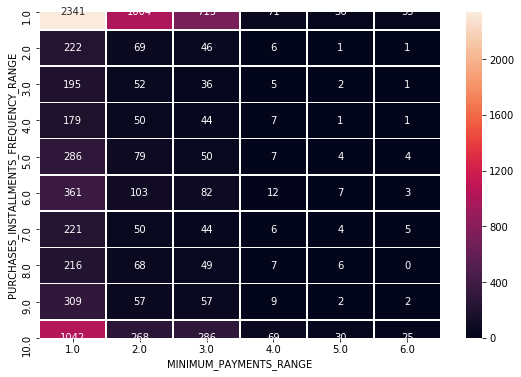

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
maxel = np.argmax(1 - abs(np.corrcoef(X.transpose())))
dc = data.columns
a = pd.crosstab(data[dc[maxel//dc.size]], data[dc[maxel%dc.size]])
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(a, annot=True, fmt="d", linewidths=.5, ax=ax)

Визуализация данных, разделённых на кластеры, с помощью PCA.

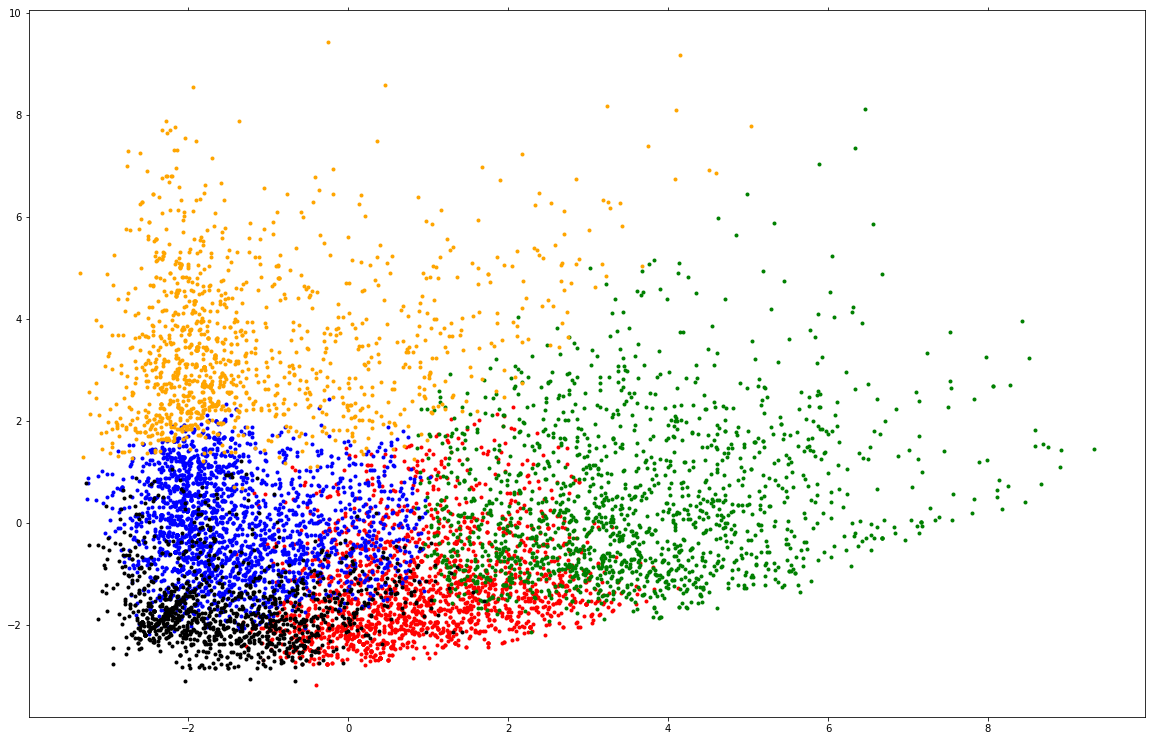

In [9]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(X)
X_PCA = pca.transform(X)
x, y = X_PCA[:, 0], X_PCA[:, 1]
colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'black', 4: 'orange'}
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(20, 13)) 
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, color=colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

Визуализация данных (косинусное расстояние), разделённых на кластеры, с помощью PCA.

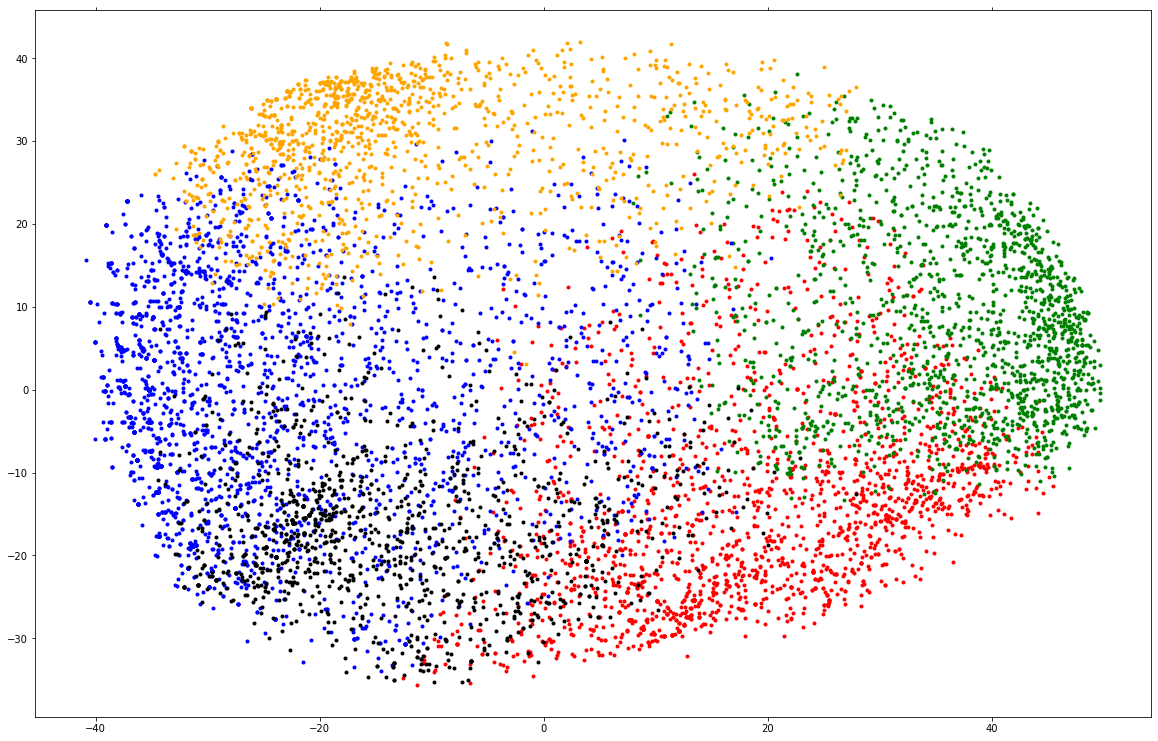

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X)
pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
x, y = X_PCA[:, 0], X_PCA[:, 1]
colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'black', 4: 'orange'}
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(20, 13)) 
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, color=colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

Визуализация данных, разделённых на кластеры, с помощью tSNE.

In [6]:
from sklearn.manifold import TSNE
tsne=TSNE()
show_reduced = tsne.fit_transform(X)

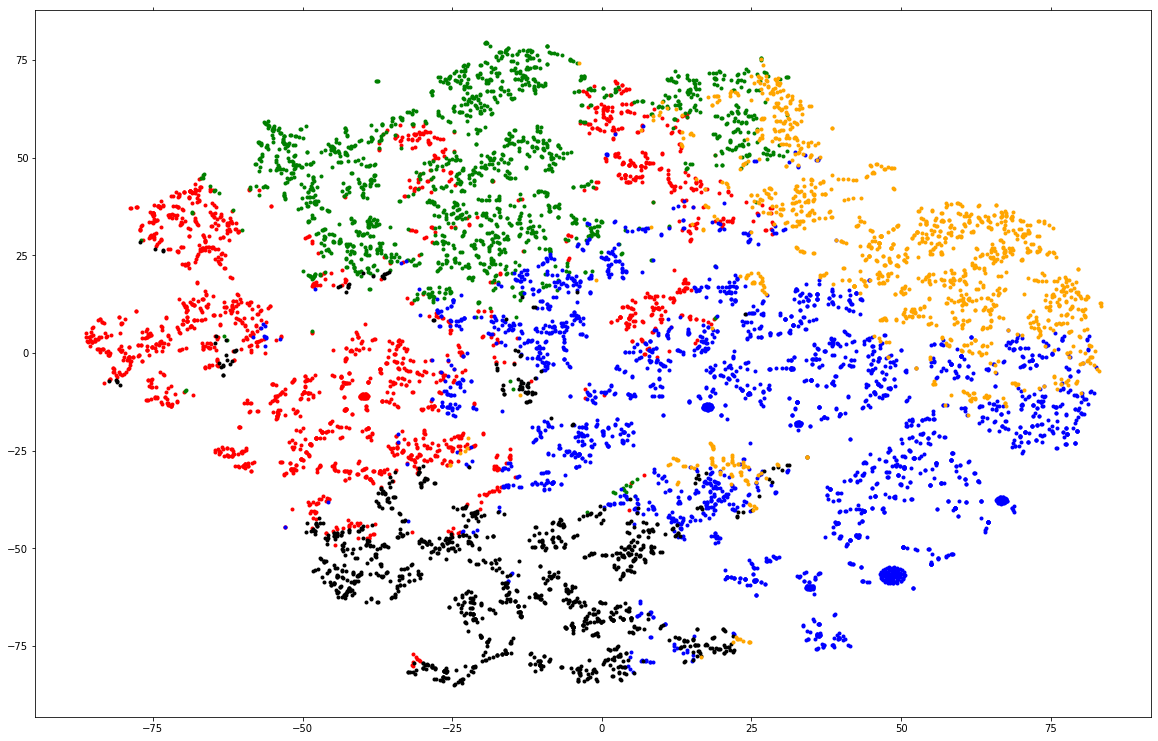

In [10]:
x, y = show_reduced[:, 0], show_reduced[:, 1]
colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'black', 4: 'orange'}
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(20, 13)) 
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, color=colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

Визуализация данных (косинусное расстояние), разделённых на кластеры, с помощью tSNE.

In [12]:
tsne=TSNE()
show_reduced_cos = tsne.fit_transform(dist)

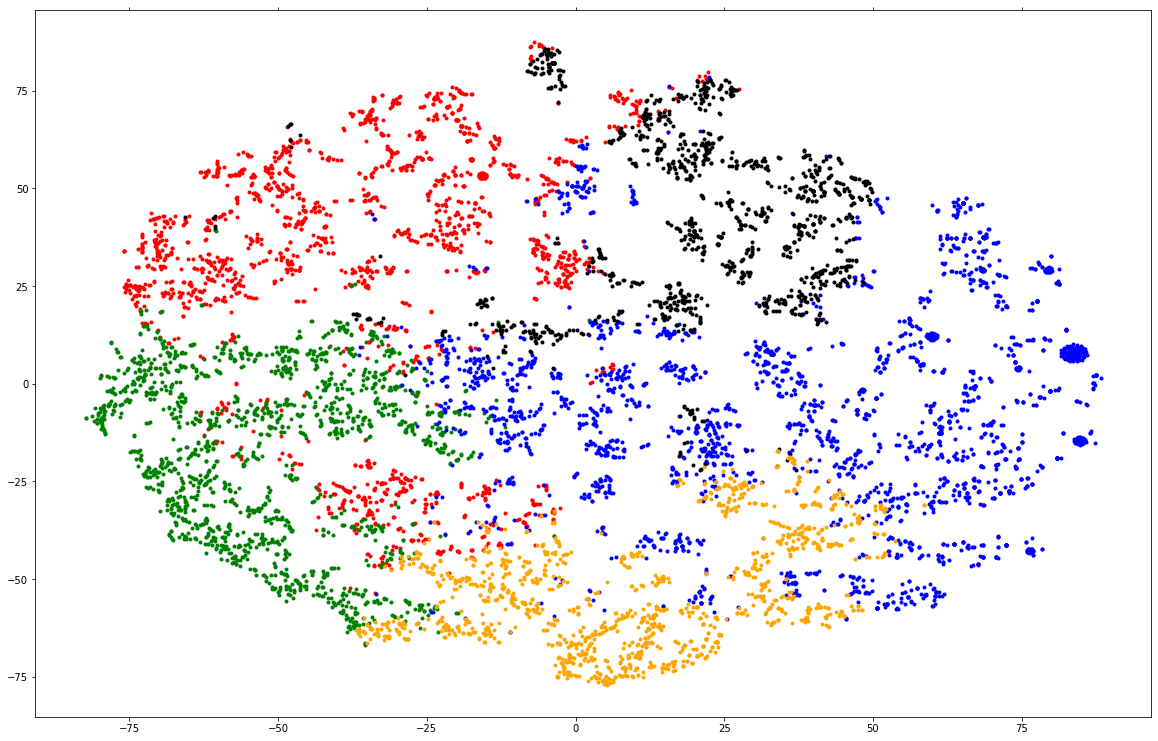

In [14]:
x, y = show_reduced_cos[:, 0], show_reduced_cos[:, 1]
colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'black', 4: 'orange'}
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(20, 13)) 
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, color=colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')